In [1]:
import numpy as np
import pandas as pd
import ipdb
import pickle
from tqdm import tqdm

from training.utils import load_obj, save_obj
from training.data import load_data
from training.dataset import _preprocess_call_data, preprocess_and_make_dataset

from training.modelling.metrics import F1, Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

CONFIG = {
    'pilot_data': 'feb16-mar15_data',
    'current_week': 12,
    'calling_files': ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521', '435_week5_240521', '600_week6_310521', '700_week7_070621', '1000_week8_140621', '1000_week9_210621', '1000_week10_280621', '1000_week11_050721'],
    'pilot_dates' : ['2021-04-26', '2021-05-03', '2021-05-10', '2021-05-17', '2021-05-24', '2021-05-31', '2021-06-07', '2021-06-14', '2021-06-21', '2021-06-28', '2021-07-05', '2021-07-12']
}

assert len(CONFIG['calling_files']) == CONFIG['current_week'] - 1
assert len(CONFIG['pilot_dates']) == CONFIG['current_week']

pilot_beneficiary_data, pilot_call_data = load_data(CONFIG['pilot_data'])
pilot_call_data = _preprocess_call_data(pilot_call_data)

complete_group = pd.read_csv('outputs/individual_clustering/weekly_kmeans_pilot_stats_40.csv')
all_user_ids = complete_group['user_id'].to_list()
rmab_group = pd.read_csv('outputs/pilot_outputs/rmab_pilot.csv')
round_robin_group = pd.read_csv('outputs/pilot_outputs/round_robin_pilot.csv')

rmab_user_ids = rmab_group['user_id'].to_list()
round_robin_user_ids = round_robin_group['user_id'].to_list()

arm_dict = {}
for user_id in rmab_user_ids:
    arm_dict[user_id] = 'rmab'
for user_id in round_robin_user_ids:
    arm_dict[user_id] = 'round_robin'

with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()


2021-08-30 15:31:23,133 - INFO - _init_num_threads - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-08-30 15:31:23,134 - INFO - _init_num_threads - NumExpr defaulting to 8 threads.
2021-08-30 15:31:26,071 - DEBUG - <module> - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2021-08-30 15:31:26,374 - DEBUG - <module> - Creating converter from 7 to 5
2021-08-30 15:31:26,375 - DEBUG - <module> - Creating converter from 5 to 7
2021-08-30 15:31:26,375 - DEBUG - <module> - Creating converter from 7 to 5
2021-08-30 15:31:26,376 - DEBUG - <module> - Creating converter from 5 to 7
2021-08-30 15:31:27,122 - INFO - load_data - Loading data from folder 'feb16-mar15_data'
2021-08-30 15:31:27,133 - INFO - load_call_data - Found 1 files in 'feb16-mar15_data/call'.
2021-08-30 15:31:27,133 - INFO - load_call_data - Loading and cleaning call data.
100%|██████████| 1/1 [00:

2021-08-30 15:31:41,832 - WARNING - gest_age_to_list - introivr is not a valid gestation age.


2021-08-30 15:31:42,187 - INFO - load_call_data - Call data contains 842588 relevant call records for 23516 beneficiaries.
2021-08-30 15:31:42,202 - INFO - load_data - Successfully loaded and cleaned beneficiary and call data.
2021-08-30 15:31:42,203 - INFO - load_data - Beneficiary data contains data for 23516 beneficiaries
2021-08-30 15:31:42,211 - INFO - load_data - Call data contains 842588 call records for 23516 beneficiaries
/Users/vermashresth/Documents/armman-pipeline-latest/training/dataset.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["duration"] = data["duration"].astype('uint8')
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifi

In [2]:
earliest_date = pd.to_datetime("2018-01-01", format="%Y-%m-%d") + pd.to_timedelta(pilot_call_data['startdate'].min(), unit='d')
n_past_weeks = (pd.to_datetime(CONFIG['pilot_dates'][0], format="%Y-%m-%d") - earliest_date).days//7+1
past_dates = [ pd.to_datetime(CONFIG['pilot_dates'][0], format="%Y-%m-%d") +  pd.to_timedelta(7*(-i), unit='d') for i in range(1, n_past_weeks+1)]
past_dates_labels = [f'week-minus{i}' for i in range(1, n_past_weeks+1)]


In [3]:

intervention_dict = {}
for file in CONFIG['calling_files']:
    with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
        for line in fr:
            user_id = int(line.strip())
            if user_id not in intervention_dict:
                intervention_dict[user_id] = [file.split('_')[1]]
            else:
                intervention_dict[user_id].append(file.split('_')[1])

# ipdb.set_trace()

out_dict = {'user_id': [], 'cluster': [], 'arm': [], 'registration_date': [], 'intervention_week': [], 'week1_whittle': [], 'after_intervention_E/C' : []}
out_dict['week{}_whittle'.format(CONFIG['current_week'])] = []
for i in range(CONFIG['current_week']):
    out_dict['week{}_E/C'.format(i)] = []

for user_id in tqdm(all_user_ids):
    out_dict['user_id'].append(user_id)
    curr_row = complete_group[complete_group['user_id'] == user_id]
    curr_cluster = curr_row['cluster'].item()
    out_dict['cluster'].append(curr_cluster)
    out_dict['registration_date'].append(curr_row['registration_date'].item())
    if user_id in arm_dict:
        out_dict['arm'].append(arm_dict[user_id])
    else:
        out_dict['arm'].append('control')

    if user_id in intervention_dict:
        out_dict['intervention_week'].append(intervention_dict[user_id][-1])
    else:
        out_dict['intervention_week'].append('')

    curr_state = None
    countc, counte = 0, 0
    for i, date_val in enumerate(CONFIG['pilot_dates']):
        pilot_date_num = (pd.to_datetime(date_val, format="%Y-%m-%d") - pd.to_datetime("2018-01-01", format="%Y-%m-%d")).days
        
        past_days_calls = pilot_call_data[
            (pilot_call_data["user_id"]==user_id)&
            (pilot_call_data["startdate"]<pilot_date_num)&
            (pilot_call_data["startdate"]>=pilot_date_num - 7)
        ]

        past_days_connections = past_days_calls[past_days_calls['duration']>0].shape[0]
        past_days_engagements = past_days_calls[past_days_calls['duration'] >= 30].shape[0]

        if past_days_engagements == 0:
            curr_state = 7
        else:
            curr_state = 6
        
        if len(out_dict['intervention_week'][-1]) > 0 and i > int(out_dict['intervention_week'][-1][4:]):
            countc += past_days_connections
            counte += past_days_engagements
        
        out_dict['week{}_E/C'.format(i)].append('{}/{}'.format(past_days_engagements, past_days_connections))
    
    if user_id in intervention_dict and int(intervention_dict[user_id][-1][4:]) > CONFIG['current_week'] - 4:
        curr_state -= 6
    
    out_dict['after_intervention_E/C'].append('{}/{}'.format(counte, countc))

    out_dict['week{}_whittle'.format(CONFIG['current_week'])].append(m_values[curr_cluster, curr_state])
    out_dict['week1_whittle'].append(curr_row['whittle_index'].item())

df = pd.DataFrame(out_dict)
# df = df.sort_values('week1_whittle', ascending=False)
# df.to_csv('outputs/analysis_lists/all_big_analysis_week_{}.csv'.format(CONFIG['current_week']))


100%|██████████| 23003/23003 [15:16<00:00, 25.11it/s]


In [4]:
df = pd.DataFrame(out_dict)
df

,user_id,cluster,arm,registration_date,intervention_week,week1_whittle,after_intervention_E/C,week12_whittle,week0_E/C,week1_E/C,week2_E/C,week3_E/C,week4_E/C,week5_E/C,week6_E/C,week7_E/C,week8_E/C,week9_E/C,week10_E/C,week11_E/C
0,2394384,29,rmab,1144.0,week1,0.865692,20/20,-0.387939,0/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2
1,2388891,29,control,1134.0,,0.865692,0/0,0.865692,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1/2,0/0,0/0
2,2404208,29,round_robin,1158.0,,0.865692,0/0,0.865692,0/0,3/3,0/0,1/1,0/0,2/2,1/1,1/1,2/2,0/0,0/0,0/0
3,2388931,29,rmab,1144.0,week1,0.865692,14/20,-0.387939,0/2,0/2,0/2,1/2,1/2,2/2,1/2,1/2,2/2,2/2,2/2,2/2
4,2392202,29,rmab,1137.0,week1,0.865692,0/0,0.865692,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22998,2400463,34,control,1157.0,,-0.882812,0/0,-0.882812,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0,0/0,0/0
22999,2398012,34,rmab,1155.0,,-0.882812,0/0,-0.882812,0/1,0/1,0/1,0/0,0/1,0/1,0/2,0/2,0/0,0/0,0/0,0/1
23000,2397484,34,control,1142.0,,-0.882812,0/0,-0.882812,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/2,0/0
23001,2397539,34,rmab,1151.0,,-0.882812,0/0,0.145004,0/1,0/1,0/0,0/0,0/1,0/0,0/1,0/0,0/0,0/2,0/0,1/1


In [5]:
for i in range(n_past_weeks):
    df[f'week{-(i+1)}_E/C'] = ''
for user_id in tqdm(all_user_ids):
    for i, date_val in enumerate(past_dates): 
        pilot_date_num = (pd.to_datetime(date_val, format="%Y-%m-%d") - pd.to_datetime("2018-01-01", format="%Y-%m-%d")).days
        
        past_days_calls = pilot_call_data[
            (pilot_call_data["user_id"]==user_id)&
            (pilot_call_data["startdate"]<pilot_date_num)&
            (pilot_call_data["startdate"]>=pilot_date_num - 7)
        ]

        past_days_connections = past_days_calls[past_days_calls['duration']>0].shape[0]
        past_days_engagements = past_days_calls[past_days_calls['duration'] >= 30].shape[0]
        
        df.loc[df.user_id==user_id, f'week{-(i+1)}_E/C'] = '{}/{}'.format(past_days_engagements, past_days_connections)
        

100%|██████████| 23003/23003 [20:06<00:00, 19.07it/s]


In [7]:
df.to_csv('outputs/analysis_lists/all_big_analysis_week_{}.csv'.format(CONFIG['current_week']))
df

,user_id,cluster,arm,registration_date,intervention_week,week1_whittle,after_intervention_E/C,week12_whittle,week0_E/C,week1_E/C,...,week-1_E/C,week-2_E/C,week-3_E/C,week-4_E/C,week-5_E/C,week-6_E/C,week-7_E/C,week-8_E/C,week-9_E/C,week-10_E/C
0,2394384,29,rmab,1144.0,week1,0.865692,20/20,-0.387939,0/2,2/2,...,0/2,0/2,2/4,2/2,2/2,1/2,1/2,1/1,0/0,0/0
1,2388891,29,control,1134.0,,0.865692,0/0,0.865692,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0
2,2404208,29,round_robin,1158.0,,0.865692,0/0,0.865692,0/0,3/3,...,1/1,1/1,1/1,1/1,1/1,1/1,0/0,0/0,0/0,0/0
3,2388931,29,rmab,1144.0,week1,0.865692,14/20,-0.387939,0/2,0/2,...,1/2,0/2,0/2,0/2,2/2,1/2,0/2,1/2,0/0,0/0
4,2392202,29,rmab,1137.0,week1,0.865692,0/0,0.865692,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22998,2400463,34,control,1157.0,,-0.882812,0/0,-0.882812,0/0,0/0,...,0/0,0/0,0/1,0/1,0/1,0/2,1/1,0/0,0/0,0/0
22999,2398012,34,rmab,1155.0,,-0.882812,0/0,-0.882812,0/1,0/1,...,0/2,1/2,0/1,0/2,0/2,0/2,0/2,0/0,0/0,0/0
23000,2397484,34,control,1142.0,,-0.882812,0/0,-0.882812,0/0,0/0,...,0/0,0/0,0/0,0/0,0/1,0/1,0/0,0/0,0/0,0/0
23001,2397539,34,rmab,1151.0,,-0.882812,0/0,0.145004,0/1,0/1,...,1/2,1/1,0/1,0/0,2/2,0/0,0/1,0/0,0/0,0/0


In [10]:
from matplotlib.pyplot import get
import numpy as np
import pandas as pd
import sys
import os
import pickle
import csv
import ipdb
from tqdm import tqdm
from collections import OrderedDict, defaultdict
# import random

from training.utils import load_obj, save_obj
from training.data import load_data
from training.dataset import _preprocess_call_data, preprocess_and_make_dataset

from training.modelling.metrics import F1, Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

np.random.seed(1)

CONFIG = {
    'pilot_data': 'feb16-mar15_data',
    'current_week': 11,
    'week': 'week11'
}
T = 22


pilot_beneficiary_data, pilot_call_data = load_data(CONFIG['pilot_data'])
pilot_call_data = _preprocess_call_data(pilot_call_data)

complete_group = pd.read_csv('outputs/individual_clustering/weekly_kmeans_pilot_stats_40.csv')
all_user_ids = complete_group['user_id'].to_list()
rmab_group = pd.read_csv('outputs/pilot_outputs/rmab_pilot.csv')
round_robin_group = pd.read_csv('outputs/pilot_outputs/round_robin_pilot.csv')

rmab_user_ids = rmab_group['user_id'].to_list()
round_robin_user_ids = round_robin_group['user_id'].to_list()

arm_dict = {}
for user_id in rmab_user_ids:
    arm_dict[user_id] = 'rmab'
for user_id in round_robin_user_ids:
    arm_dict[user_id] = 'round_robin'

with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

intervention_dict = {}
group_cluster_size = defaultdict(lambda: defaultdict(lambda: 0))
for file in ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521', '435_week5_240521', '600_week6_310521', '700_week7_070621', '1000_week8_140621']:
    with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
        for line in fr:
            user_id = int(line.strip())
            curr_cluster = complete_group[complete_group['user_id'] == user_id]['cluster'].item()
            if user_id not in intervention_dict:
                intervention_dict[user_id] = [int(file.split('_')[1][4:])]
            else:
                intervention_dict[user_id].append(int(file.split('_')[1][4:]))
            if user_id in rmab_user_ids:
                group_cluster_size['rmab'][curr_cluster] += 1
            elif user_id in round_robin_user_ids:
                group_cluster_size['round_robin'][curr_cluster] += 1

rmab_cluster_list = [(group_cluster_size['rmab'][cluster], cluster) for cluster in range(40)]
round_robin_cluster_list = [(group_cluster_size['round_robin'][cluster], cluster) for cluster in range(40)]

rmab_cluster_list = sorted(rmab_cluster_list, reverse=True)[:5]
round_robin_cluster_list = sorted(round_robin_cluster_list, reverse=True)[:5]

top_cluster_list = {'rmab': rmab_cluster_list, 'round_robin': round_robin_cluster_list}


df = pd.read_csv('outputs/analysis_lists/all_big_analysis_week_12.csv')

out_dict = {'user_id': [], 'pre-action state': [], 'action': [], 'post-action state': []}

for user_id in tqdm(all_user_ids):
    curr_row = df[df['user_id'] == user_id]

    engagements = []
    for i in range(T):
        counte = int(curr_row['week{}_E/C'.format(i-10)].item().split('/')[0])
        engagements.append(counte)

    if user_id in intervention_dict:
        user_intervention_list = intervention_dict[user_id]
    else:
        user_intervention_list = []

    assert len(engagements) == T
    for i in range(T-1):
        start_state = 'L' if engagements[i] > 0 else 'H'
        next_state = 'L' if engagements[i + 1] > 0 else 'H'
        action = 'Intervention' if i-10 in user_intervention_list else 'No Intervention'
        out_dict['user_id'].append(user_id)
        out_dict['pre-action state'].append(start_state)
        out_dict['action'].append(action)
        out_dict['post-action state'].append(next_state)

transitions_df = pd.DataFrame(out_dict)

# transitions_df.to_csv('outputs/pilot_transitions.csv')

2021-08-30 17:14:05,026 - DEBUG - wrapper - (private) matplotlib data path: /Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data
2021-08-30 17:14:05,027 - DEBUG - wrapper - matplotlib data path: /Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data
2021-08-30 17:14:05,032 - DEBUG - wrapper - CONFIGDIR=/Users/vermashresth/.matplotlib
2021-08-30 17:14:05,035 - DEBUG - <module> - matplotlib version 3.3.2
2021-08-30 17:14:05,035 - DEBUG - <module> - interactive is False
2021-08-30 17:14:05,036 - DEBUG - <module> - platform is darwin
2021-08-30 17:14:05,037 - DEBUG - <module> - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_frozen_importlib_external', '_io', 'marshal', 'posix', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'generic

2021-08-30 17:14:05,091 - DEBUG - wrapper - CACHEDIR=/Users/vermashresth/.matplotlib
2021-08-30 17:14:05,095 - DEBUG - <module> - Using fontManager instance from /Users/vermashresth/.matplotlib/fontlist-v330.json
2021-08-30 17:14:05,233 - DEBUG - switch_backend - Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2021-08-30 17:14:05,235 - DEBUG - switch_backend - Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2021-08-30 17:14:05,238 - INFO - load_data - Loading data from folder 'feb16-mar15_data'
2021-08-30 17:14:05,249 - INFO - load_call_data - Found 1 files in 'feb16-mar15_data/call'.
2021-08-30 17:14:05,250 - INFO - load_call_data - Loading and cleaning call data.
100%|██████████| 1/1 [00:10<00:00, 10.75s/it]
2021-08-30 17:14:20,107 - WARNING - gest_age_to_list - introivr is not a valid gestation age.
2021-08-30 17:14:20,123 - WARNING - gest_age_to_list - introivr is not a valid gestation age.
2021-08-30 17:14:20,126 - WARNING - gest_age

2021-08-30 17:14:20,366 - WARNING - gest_age_to_list - introivr is not a valid gestation age.


2021-08-30 17:14:20,738 - INFO - load_call_data - Call data contains 842588 relevant call records for 23516 beneficiaries.
2021-08-30 17:14:20,760 - INFO - load_data - Successfully loaded and cleaned beneficiary and call data.
2021-08-30 17:14:20,761 - INFO - load_data - Beneficiary data contains data for 23516 beneficiaries
2021-08-30 17:14:20,770 - INFO - load_data - Call data contains 842588 call records for 23516 beneficiaries
/Users/vermashresth/Documents/armman-pipeline-latest/training/dataset.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["duration"] = data["duration"].astype('uint8')
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifi

In [13]:
transitions_df.to_csv('outputs/pilot_transitions_5months.csv')

In [14]:
def get_transition_probabilities(beneficiaries, transitions, min_support=1):
    transitions = transitions[transitions['user_id'].isin(beneficiaries)]

    i_transitions = transitions[transitions['action']=='Intervention']
    n_i_transitions = transitions[transitions['action']=='No Intervention']

    i_L = i_transitions[i_transitions['pre-action state']=="L"]
    i_H = i_transitions[i_transitions['pre-action state']=="H"]

    i_L_L = i_L[i_L['post-action state']=="L"]
    i_L_H = i_L[i_L['post-action state']=="H"]

    i_H_L = i_H[i_H['post-action state']=="L"]
    i_H_H = i_H[i_H['post-action state']=="H"]

    n_i_L = n_i_transitions[n_i_transitions['pre-action state']=="L"]
    n_i_H = n_i_transitions[n_i_transitions['pre-action state']=="H"]

    n_i_L_L = n_i_L[n_i_L['post-action state']=="L"]
    n_i_L_H = n_i_L[n_i_L['post-action state']=="H"]

    n_i_H_L = n_i_H[n_i_H['post-action state']=="L"]
    n_i_H_H = n_i_H[n_i_H['post-action state']=="H"]

    transition_probabilities = dict()
    if i_L.shape[0] >= min_support:
        transition_probabilities['P(L, I, L)'] = i_L_L.shape[0] / i_L.shape[0]
        transition_probabilities['P(L, I, H)'] = i_L_H.shape[0] / i_L.shape[0]
    else:
        transition_probabilities['P(L, I, L)'] = np.nan
        transition_probabilities['P(L, I, H)'] = np.nan

    if i_H.shape[0] >= min_support:
        transition_probabilities['P(H, I, L)'] = i_H_L.shape[0] / i_H.shape[0]
        transition_probabilities['P(H, I, H)'] = i_H_H.shape[0] / i_H.shape[0]
    else:
        transition_probabilities['P(H, I, L)'] = np.nan
        transition_probabilities['P(H, I, H)'] = np.nan
    
    if n_i_L.shape[0] >= min_support:
        transition_probabilities['P(L, N, L)'] = n_i_L_L.shape[0] / n_i_L.shape[0]
        transition_probabilities['P(L, N, H)'] = n_i_L_H.shape[0] / n_i_L.shape[0]
    else:
        transition_probabilities['P(L, N, L)'] = np.nan
        transition_probabilities['P(L, N, H)'] = np.nan

    if n_i_H.shape[0] >= min_support:
        transition_probabilities['P(H, N, L)'] = n_i_H_L.shape[0] / n_i_H.shape[0]
        transition_probabilities['P(H, N, H)'] = n_i_H_H.shape[0] / n_i_H.shape[0]
    else:
        transition_probabilities['P(H, N, L)'] = np.nan
        transition_probabilities['P(H, N, H)'] = np.nan

    return transition_probabilities, {'P(L, I, L)': i_L_L.shape[0], 'P(L, I, H)': i_L_H.shape[0], 'P(H, I, L)': i_H_L.shape[0], 'P(H, I, H)': i_H_H.shape[0], 'P(L, N, L)': n_i_L_L.shape[0], 'P(L, N, H)': n_i_L_H.shape[0], 'P(H, N, L)': n_i_H_L.shape[0], 'P(H, N, H)': n_i_H_H.shape[0]}


In [15]:
user_probs, sup = get_transition_probabilities([all_user_ids[0]], transitions_df)


In [22]:
all_probs = pd.DataFrame(columns = ['user_id'] + list(user_probs.keys()))
for user_id in tqdm(all_user_ids):
        user_probs, sup = get_transition_probabilities([user_id], transitions_df, 1)
        user_probs['user_id'] = user_id
        all_probs = all_probs.append(user_probs, ignore_index=True)

100%|██████████| 23003/23003 [03:25<00:00, 111.76it/s]


In [23]:
all_probs

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",user_id
0,2394384.0,1.0,0.0,NaN,NaN,0.933333,0.066667,0.400000,0.600000,2394384.0
1,2388891.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.050000,0.950000,2388891.0
2,2404208.0,NaN,NaN,NaN,NaN,0.666667,0.333333,0.444444,0.555556,2404208.0
3,2388931.0,NaN,NaN,0.0,1.0,0.750000,0.250000,0.500000,0.500000,2388931.0
4,2392202.0,NaN,NaN,0.0,1.0,NaN,NaN,0.000000,1.000000,2392202.0
...,...,...,...,...,...,...,...,...,...,...
22998,2400463.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.050000,0.950000,2400463.0
22999,2398012.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.050000,0.950000,2398012.0
23000,2397484.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,2397484.0
23001,2397539.0,NaN,NaN,NaN,NaN,0.333333,0.666667,0.166667,0.833333,2397539.0


In [25]:
all_probs['P(H, N, L)'].isna().sum(), all_probs['P(L, N, L)'].isna().sum(), all_probs[~all_probs['P(H, N, L)'].isna() & ~all_probs['P(L, N, L)'].isna()].shape

(0, 3338, (19665, 10))

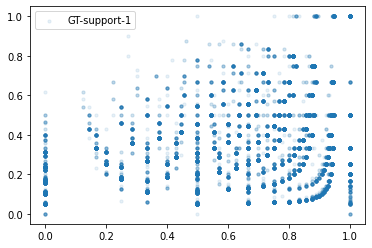

In [26]:
import matplotlib.pyplot as plt
plt.scatter(all_probs['P(L, N, L)'], all_probs['P(H, N, L)'], s=10, label='GT-support-1', alpha=0.1)
# plt.scatter(gt[:, 0], gt[:, 1], s=10, label='GT-support-3', alpha=0.1)
plt.legend()

In [27]:
all_probs[all_probs['P(L, N, L)'].isna()]

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",user_id
4,2392202.0,NaN,NaN,0.0,1.0,NaN,NaN,0.0,1.0,2392202.0
7,2394704.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2394704.0
11,2392184.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2392184.0
15,2405531.0,NaN,NaN,0.0,1.0,NaN,NaN,0.0,1.0,2405531.0
16,2398556.0,NaN,NaN,0.0,1.0,NaN,NaN,0.0,1.0,2398556.0
...,...,...,...,...,...,...,...,...,...,...
22982,2399484.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2399484.0
22984,2396051.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2396051.0
22991,2392937.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2392937.0
22997,2400456.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2400456.0


In [30]:
transitions_df[transitions_df['user_id']==2392937.0]

,user_id,pre-action state,action,post-action state
482811,2392937,H,No Intervention,H
482812,2392937,H,No Intervention,H
482813,2392937,H,No Intervention,H
482814,2392937,H,No Intervention,H
482815,2392937,H,No Intervention,H
482816,2392937,H,No Intervention,H
482817,2392937,H,No Intervention,H
482818,2392937,H,No Intervention,H
482819,2392937,H,No Intervention,H
482820,2392937,H,No Intervention,H


In [3]:
import pickle
with open('gt_beneficiary_probs.pkl', 'rb') as fr:
  gt= pickle.load(fr)
fr.close()

In [8]:
!grep -lr 'gt_benef' .

./ANALYSIS - Pilot Clustering, Pilot vs Offline Transition Prob Shift.ipynb
./HELPER NOTEBOOK - Determining Pilot Transitions.ipynb
./.ipynb_checkpoints/ANALYSIS - Pilot Clustering, Pilot vs Offline Transition Prob Shift-checkpoint.ipynb
./.ipynb_checkpoints/ANALYSIS - Pilot Transitions Error-checkpoint.ipynb
